# Разработка дизайна AB теста

In [1]:
#  Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.stats.power as smp
from scipy.stats import mannwhitneyu

## 0. Загружаем необходимые датафреймы

In [ ]:
#датасет с коммуникациями
df_emp_result = pd.read_csv('../data/src/communications.csv', sep=';')

In [ ]:
df_emp_result.head()

,communication_id,communication_dt,employee_id,communication_score,util_flg
0,177074281189583840,2023-02-07 00:00:00,269d837a-fada-308d-d4ae-ab28ca2d57e4,85,0
1,189925315406757324,2023-07-29 00:00:00,e6384711-4917-13d2-9bc6-3fc5eeb5ba4f,100,0
2,321818238739717242,2023-09-06 00:00:00,ab541d87-4c7b-c19a-b776-42849e02b89f,43,1
3,192259329962028989,2023-06-19 00:00:00,0a0a0c8a-aa00-ade5-0f74-a3f0ca981ed7,100,1
4,705274671052151857,2023-08-11 00:00:00,f93882cb-d8fc-7fb7-94c1-011d63be6fb6,46,0


In [ ]:
#преобразуем столбец с датой
df_emp_result['communication_dt'] = pd.to_datetime(df_emp_result['communication_dt'])

In [ ]:
#получим средний показатель каждого сотрудника по уровню коммуникаций и конверсии
df_emp_mean_result = df_emp_result.groupby('employee_id')[['communication_score', 'util_flg']].mean()
df_emp_mean_result

,communication_score,util_flg
employee_id,,
0004d0b5-9e19-461f-f126-e3a08a814c33,57.144464,0.746972
00411460-f7c9-2d21-24a6-7ea0f4cb5f85,57.152452,0.766525
006f52e9-102a-8d3b-e2fe-5614f42ba989,61.333500,0.763355
0070d23b-06b1-486a-538c-0eaa45dd167a,58.648239,0.758395
008bd5ad-93b7-54d5-0033-8c253d9c1770,56.645145,0.752252
...,...,...
fface838-5abb-f94b-4593-a0ed53a0c70f,58.311325,0.768909
ffd52f3c-7e12-435a-724a-8f30fddadd9c,57.732249,0.757890
ffeabd22-3de0-d4ea-cb9a-3e6e53e5448d,58.547652,0.712722


In [ ]:
#получим количество наблюдений для каждого сотрудика
df_emp_count_per_day_result = df_emp_result.groupby(['employee_id', 'communication_dt'])[['communication_score', 'util_flg']].count()
#среднее число коммуникаций сотрудника за день
nobs_per_emp = round(df_emp_count_per_day_result['communication_score'].mean())
nobs_per_emp

10

In [ ]:
#средние показатели сотрудников за все время наблюдений
df_emp_mean_result.head()

,communication_score,util_flg
employee_id,,
0004d0b5-9e19-461f-f126-e3a08a814c33,57.144464,0.746972
00411460-f7c9-2d21-24a6-7ea0f4cb5f85,57.152452,0.766525
006f52e9-102a-8d3b-e2fe-5614f42ba989,61.333500,0.763355
0070d23b-06b1-486a-538c-0eaa45dd167a,58.648239,0.758395
008bd5ad-93b7-54d5-0033-8c253d9c1770,56.645145,0.752252


In [ ]:
#Соц_дем сотрудников
#датасет с соц_демом
df_empoyees = pd.read_csv('../data/src/employees.csv', sep=';').set_index('employee_id')
df_empoyees.head()

,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg
employee_id,,,,,,,,
0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1
ac1dd209-cbcc-5e5d-1c6e-28598e8cbbe8,M,4,32,93db85ed-909c-1383-8ff9-5ccfa94cebd9,654,0,2,1
a8c88a00-55f6-36e4-a163-a5e3d16adab7,F,5,34,9a115815-4dfa-42ca-ddbd-0694a4e9bdc8,276,1,2,1
c91591a8-d461-c286-9b9f-535ded3e213e,F,4,33,9f61408e-3afb-633e-50cd-f1b20de6f466,50,2,0,1
bc731692-9fe1-545b-f0b9-8d114ee3ecb8,M,0,33,a97da629-b098-b75c-294d-ffdc3e463904,274,1,2,1


In [ ]:
#Общее число сотрудников
emp_count = len(df_empoyees)
emp_count

2381

In [ ]:
#объединими таблицы средних показателей работников с их соц демом
df_emp_with_mean_results = pd.merge(df_emp_mean_result, df_empoyees, left_index=True, right_index=True)

In [ ]:
#переимменуем столбцы
df_emp_with_mean_results.columns = pd.Index(['communication_score_mean', 'util_flg_mean', 'sex', 'region', 'age',
       'head_employee_id', 'exp_days', 'edu_degree', 'department_id',
       'work_online_flg'],
      dtype='object')

In [ ]:
#результат добавления средних показателей работы в таблицу с соцдемом сотрудников
df_emp_with_mean_results.head()

,communication_score_mean,util_flg_mean,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg
employee_id,,,,,,,,,,
0004d0b5-9e19-461f-f126-e3a08a814c33,57.144464,0.746972,M,0,28,17e62166-fc85-86df-a4d1-bc0e1742c08b,140,2,2,0
00411460-f7c9-2d21-24a6-7ea0f4cb5f85,57.152452,0.766525,F,3,29,3c59dc04-8e88-5024-3be8-079a5c74d079,378,1,1,1
006f52e9-102a-8d3b-e2fe-5614f42ba989,61.333500,0.763355,F,0,24,182be0c5-cdcd-5072-bb18-64cdee4d3d6e,452,2,2,1
0070d23b-06b1-486a-538c-0eaa45dd167a,58.648239,0.758395,M,0,30,44f683a8-4163-b352-3afe-57c2e008bc8c,163,1,2,1
008bd5ad-93b7-54d5-0033-8c253d9c1770,56.645145,0.752252,M,4,34,a0a080f4-2e6f-13b3-a2df-133f073095dd,46,1,1,0


In [ ]:
# число сотрудников для эксперимента
statistical_sample = 2380

In [ ]:
#формируем датафрейм двойной выборки
df_empoyees_agg = df_emp_with_mean_results.sample(n=statistical_sample, replace=False, random_state=42, axis=0, ignore_index=False)

In [ ]:
df_empoyees_agg.head()

,communication_score_mean,util_flg_mean,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg
employee_id,,,,,,,,,,
98d6f58a-b0da-fbb8-6b08-3a001561bb34,58.015216,0.747253,M,2,36,698d51a1-9d8a-121c-e581-499d7b701668,1235,2,1,1
7437d136-770f-5b35-194c-b46c1653efaa,59.159186,0.767745,M,5,35,6f4922f4-5568-161a-8cdf-4ad2299f6d23,283,2,2,0
95151403-b0db-4f75-bfd8-da0b393af853,60.420846,0.781219,F,4,29,e4da3b7f-bbce-2345-d777-2b0674a318d5,233,2,1,1
d8d31bd7-78da-8bdd-5361-87c36e48892b,58.365013,0.755091,F,5,33,28dd2c79-55ce-9264-5624-0b2ff0100bde,955,2,0,0
7895fc13-088e-e37f-5119-13bac71fa66f,57.968012,0.750984,F,0,33,d09bf415-44a3-365a-46c9-077ebb5e35c3,181,2,2,0


In [ ]:
# проверяем, что сотрудники уникальные
df_empoyees_agg.index.is_unique

True

In [ ]:
#разбиваем датафрйем двойной выборки на 2 части
#формируем группу А и группу Б
np.random.seed(0)
df_empoyees_agg['group'] = np.random.choice(['A', 'B'], statistical_sample, replace=True,  p=[0.5, 0.5])

In [ ]:
df_empoyees_agg.head()

,communication_score_mean,util_flg_mean,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg,group
employee_id,,,,,,,,,,,
98d6f58a-b0da-fbb8-6b08-3a001561bb34,58.015216,0.747253,M,2,36,698d51a1-9d8a-121c-e581-499d7b701668,1235,2,1,1,B
7437d136-770f-5b35-194c-b46c1653efaa,59.159186,0.767745,M,5,35,6f4922f4-5568-161a-8cdf-4ad2299f6d23,283,2,2,0,B
95151403-b0db-4f75-bfd8-da0b393af853,60.420846,0.781219,F,4,29,e4da3b7f-bbce-2345-d777-2b0674a318d5,233,2,1,1,B
d8d31bd7-78da-8bdd-5361-87c36e48892b,58.365013,0.755091,F,5,33,28dd2c79-55ce-9264-5624-0b2ff0100bde,955,2,0,0,B
7895fc13-088e-e37f-5119-13bac71fa66f,57.968012,0.750984,F,0,33,d09bf415-44a3-365a-46c9-077ebb5e35c3,181,2,2,0,A


In [ ]:
#проверим разбиение групп
df_empoyees_agg['group'].value_counts()

group
B    1196
A    1184
Name: count, dtype: int64

In [ ]:
#средняя эффективность работников по группам А и B
group_mean_result_aggregate = df_empoyees_agg.groupby('group')[['communication_score_mean', 'util_flg_mean']].mean()
#приведем метрики к одному масштабу
group_mean_result_aggregate['util_flg_mean'] = group_mean_result_aggregate['util_flg_mean'] * 100
group_mean_result_aggregate

,communication_score_mean,util_flg_mean
group,,
A,58.515679,75.231490
B,58.582821,75.247438


## 1. Формулируем гипотезу
### В основе любого A/B теста лежит проблема (ситуация), которую нам надо решить (разрешить) или некое поведение пользователя, которое нам нужно изменить или, наоборот, закрепить. Выявив проблему, продакт менеджер формулирует гипотезу — предположение, которое либо подтверждается, либо опровергается в результате эксперимента.

### Для правильной оценки результатов выделяют два типа гипотез:

### Нулевая. Изменения ни к чему не приведут, конверсия остается прежней (задача — опровергнуть гипотезу).

### Альтернативная. Изменения приведут к повышению метрики конверсии на 5% или более или качеству общения с клиентами на 5% или более.

![Разделение выборки](../others/расчет_выборки.jpg)

## 2. Выбираем целевую, прокси и контр-метрики.
### - Целевая метрика - конверсия.
###### Целевая метрика — метрика, на которую вы намерены позитивно повлиять.
### - Прокси метрика - качество разговоров.
##### Прокси метрика — это косвенная мера целевой метрики, с которой она сильно коррелирует.
### - Контр метрики - количество рабочих часов сотрудников для работы с клиентами, а также количество времени, потраченное на одного клиента.
##### Контр метрики — те метрики, которые вы можете подвергнуть падению в вашем АВ тесте.

## 3. Способ тестирования гипотезы.
### Сотрудники из выборки А обучаются в прежнем режиме, сотрудники из выборки Б проходят курсы с соответствие с новой системой рекомендаций.

## 4. Определяем допустимый уровень значимости
### Допустимый уровень значимости (α - Альфа) - это вероятность того, что мы ошибочно отклоняем нулевую гипотезу, то есть гипотезу о том, что между двумя группами не существует статистически значимых различий. Обычно допустимый уровень значимости для А/В тестирования составляет 0,05 (или 5%). Это означает, что если у нас есть статистически значимый результат с уровнем значимости 0,05, то вероятность того, что мы сделали ошибку и нулевая гипотеза на самом деле верна, составляет 5%.

## 5.Считаем Minimum Detectable Effect
### MDE (Minimum Detectable Effect) - это минимальный обнаруживаемый эффект, т.е. минимальное изменение метрики, которое вы сможете обнаружить с заданной вероятностью и статистической значимостью в А/В тесте.

## При текущем размере выборки - 2381 человек - минимально обнаруживаемый эффект составляет около 5%. Расчет можно произвести в онлайн калькуляторе ниже. В противном случае резко возрастает продолжительность АБ теста.

In [ ]:
#Сайт для расчета выборки
'https://www.evanmiller.org/ab-testing/sample-size.html'

'https://www.evanmiller.org/ab-testing/sample-size.html'

## Примем мощность АB теста 0.8 (вероятность увидеть различия там, где они действительно есть), p_value 0.05 и исходя их этого вычислим минимальное количество наблюдений для теста по методу Хи квадрат.

In [ ]:
#параментры расчета продолжительности теста
power = 0.8
pval = 0.05
group_count = 1180

In [ ]:
#Воспользуемся критирием Хи квадрат
chipower = smp.GofChisquarePower()

In [ ]:
#ф-ция расчета параметра effect_size для ф-ции chipower.solve_power(), где p0 - метрика контрольной группы, а р1 - тестовой
def chi2_effect_size(p0:float, p1:float):
    return np.sqrt((p0 - p1)**2/p0)

In [ ]:
# средние метрики по коммуникации
p0_communication_score_mean, p1_communication_score_mean = group_mean_result_aggregate['communication_score_mean'].values
# средние метрики по коммуникации
p0_util_flg_mean, p1_util_flg_mean = group_mean_result_aggregate['util_flg_mean'].values

In [ ]:
# найдем число наблюдений для определения изменения уровня коммуникации
count_nobs_for_communication = round(chipower.solve_power(effect_size =chi2_effect_size(p0_communication_score_mean, p1_communication_score_mean), nobs=None, alpha = pval, power=power))
count_nobs_for_communication

101882

In [ ]:
# найдем число наблюдений для определения изменения уровня конверсии
count_nob_sutil_flg_mean = round(chipower.solve_power(effect_size =chi2_effect_size(p0_util_flg_mean, p1_util_flg_mean), nobs=None, alpha = pval, power=power))
count_nob_sutil_flg_mean

2321528

### Т.к. среднее количество коммуникаций за день на сотрудника - 10, в группах по 1180 человек, то исходя из расчитанных параметров count_nobs_for_communication (число наблюдений по коммуникациям) и count_nob_sutil_flg_mean (числов наблюдений для конверции) получаем:

In [ ]:
#минимальное число дней для АБ теста по уровню коммуникаций
AB_test_days_for_communication = round(count_nobs_for_communication*2/group_count/nobs_per_emp)
# т.к. групп 2, умножаем число наблюдений на 2 выше
AB_test_days_for_communication

17

In [ ]:
#минимальное число дней для АБ теста по уровню конверсии
AB_test_days_for_util_flg_mean = round(count_nob_sutil_flg_mean*2/group_count/nobs_per_emp)
# т.к. групп 2, умножаем число наблюдений на 2 выше
AB_test_days_for_util_flg_mean

393

## 6.Определяем продолжительность тестирования.
## Для получения достоверных результатов по уровню коммуникации рекомендуется проводить тестирование минимум 17 дней, для определения уровня разности по конверсии - 393 дня.

## 7. Определяем сегмент АВ теста

## В нашем исследовании принимают участие 2381 сотрудник.

## Пусть А - контрольная группа, B - тестовая группа.

## Проверим распределения группы А и группы Б.

## Сравним выборки по возрасту

Text(0.5, 1.0, 'Boxplot: возраст в группах А и Б')

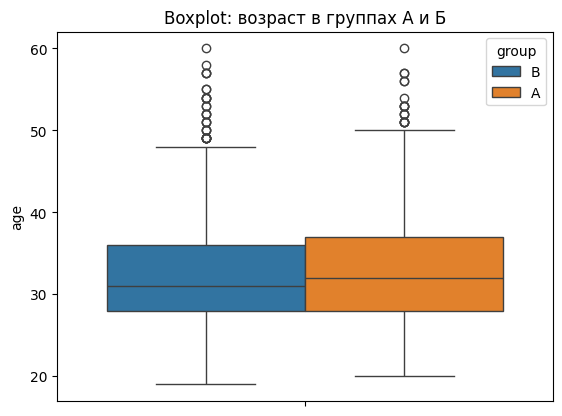

In [ ]:
sns.boxplot(data=df_empoyees_agg, hue='group', y='age');
plt.title("Boxplot: возраст в группах А и Б")

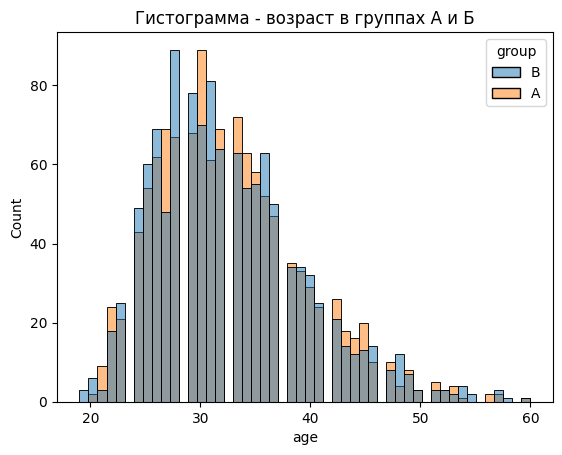

In [ ]:
sns.histplot(data=df_empoyees_agg, hue='group', x='age', bins=50);
plt.title("Гистограмма - возраст в группах А и Б");

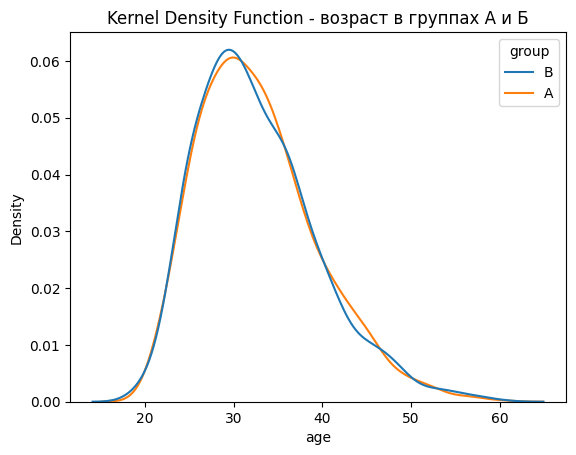

In [ ]:
sns.kdeplot(x='age', data=df_empoyees_agg, hue='group', common_norm=False);
plt.title("Kernel Density Function - возраст в группах А и Б");

## Сравним выборки по опыту работы

Text(0.5, 1.0, 'Boxplot: опыт в группах А и Б')

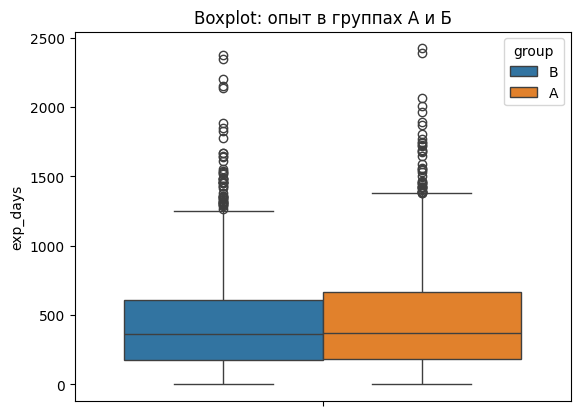

In [ ]:
sns.boxplot(data=df_empoyees_agg, hue='group', y='exp_days');
plt.title("Boxplot: опыт в группах А и Б")

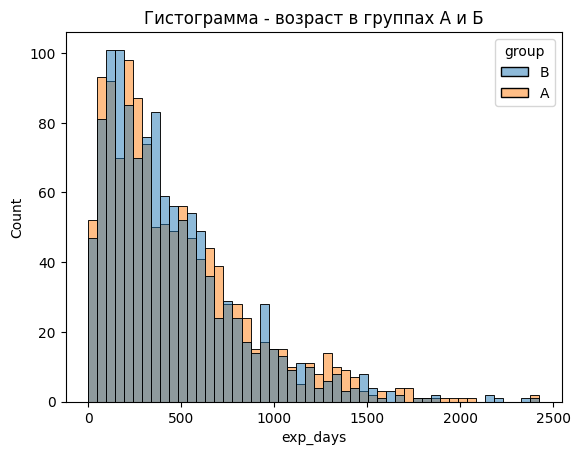

In [ ]:
sns.histplot(data=df_empoyees_agg, hue='group', x='exp_days', bins=50);
plt.title("Гистограмма - возраст в группах А и Б");

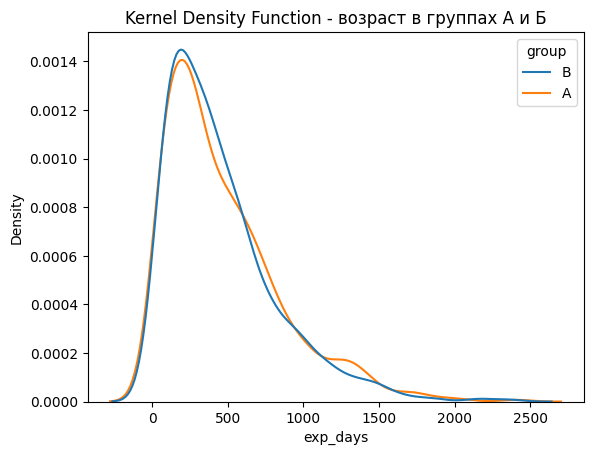

In [ ]:
sns.kdeplot(x='exp_days', data=df_empoyees_agg, hue='group', common_norm=False);
plt.title("Kernel Density Function - возраст в группах А и Б");

## Сравним распределение выборок А и Б по полу

<Axes: xlabel='sex', ylabel='count'>

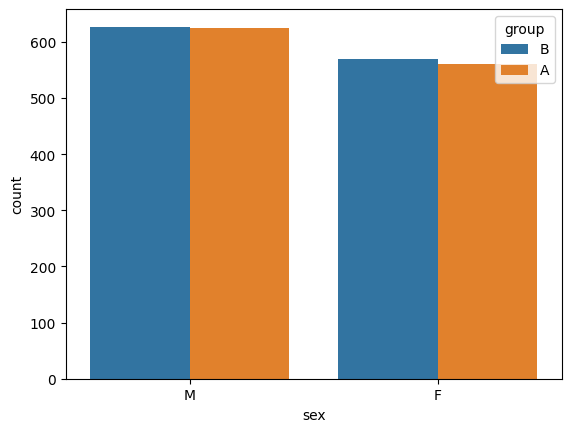

In [ ]:
sns.countplot(x ='sex', data=df_empoyees_agg, hue='group')

## Сравним распределение выборок А и Б по региону

<Axes: xlabel='region', ylabel='count'>

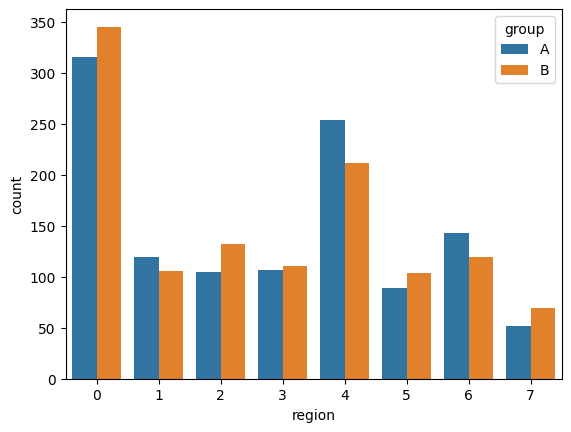

In [ ]:
sns.countplot(x ='region', data=df_empoyees_agg, hue='group')

## Сравним распределение выборок А и Б по департаменту

<Axes: xlabel='department_id', ylabel='count'>

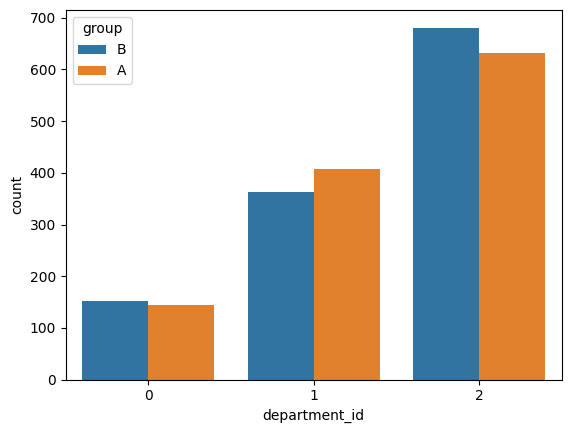

In [ ]:
sns.countplot(x ='department_id', data=df_empoyees_agg, hue='group')

## Сравним распределение выборок А и Б по образованию

<Axes: xlabel='edu_degree', ylabel='count'>

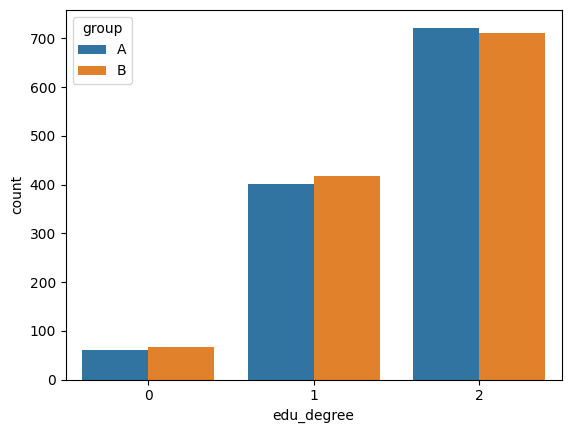

In [ ]:
sns.countplot(x ='edu_degree', data=df_empoyees_agg, hue='group')

## Сравним распределение выборок А и Б по форматы работы: (офис, удаленно)

<Axes: xlabel='work_online_flg', ylabel='count'>

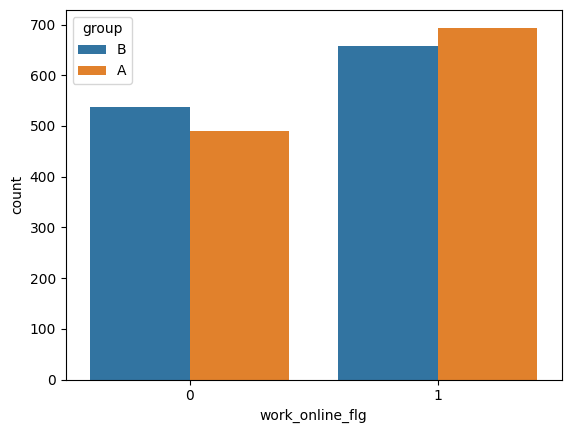

In [ ]:
sns.countplot(x ='work_online_flg', data=df_empoyees_agg, hue='group')

## U-критерий Манна — Уитни
U-критерий Манна — Уитни, который сравнивает медиану двух распределений. В частности, нулевая гипотеза для этого теста состоит в том, что две группы имеют одинаковое распределение, тогда как альтернативная гипотеза — в том, что одна группа имеет большие (или меньшие) значения, чем другая.
U-критерий Манна — Уитни не зависит от выбросов и концентрируется на центре распределения.

И вот процедура расчёта критерия:

Объедините все точки данных и ранжируйте их в порядке возрастания или убывания.

Вычислите U₁ = R₁ − n₁(n₁ + 1)/2, где R₁ — сумма рангов точек данных в первой группе, а n₁ — количество точек в первой группе.

Аналогично вычислите U₂ для второй группы.

Тестовая статистика рассчитывается как stat = min(U₁, U₂).

При нулевой гипотезе об отсутствии систематических ранговых различий между двумя распределениями (т. е. об одинаковой медиане) тестовая статистика имеет асимптотическое нормальное распределение с известным средним значением и дисперсией.

Логика за вычислением R и U такова: если все значения в первой выборке больше, чем значения во второй выборке, то R₁ = n₁(n₁ + 1)/2 и, как следствие, U₁ будет тогда равным нулю (минимально достижимое значение). В противном случае, если бы две выборки были похожи, U₁ и U₂ были бы очень близки к n₁ n₂/2 (максимально достижимое значение).

Мы проводим тест при помощи mannwhitneyu из scipy:

## U-критерий Манна — Уитни: возраст групп А и Б

In [ ]:
age_A = df_empoyees_agg['age'].loc[df_empoyees_agg['group'] == 'A']
age_B = df_empoyees_agg['age'].loc[df_empoyees_agg['group'] == 'B']
stat, p_value = mannwhitneyu(age_A, age_B)

print(f" Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")

 Mann–Whitney U Test: statistic=717361.5000, p-value=0.5774


### p-значение составляет 0.58, поэтому не отвергаем нулевую гипотезу об отсутствии различий в средних значениях в обеих группах.

## U-критерий Манна — Уитни: опыт работы групп А и Б

In [ ]:
exp_A = df_empoyees_agg['exp_days'].loc[df_empoyees_agg['group'] == 'A']
exp_B = df_empoyees_agg['exp_days'].loc[df_empoyees_agg['group'] == 'B']
stat, p_value = mannwhitneyu(exp_A, exp_B)

print(f" Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")

 Mann–Whitney U Test: statistic=719101.5000, p-value=0.5090


### p-значение составляет 0.51, поэтому не отвергаем нулевую гипотезу об отсутствии различий в средних значениях в обеих группах.

## Для определения гомогенности категориальных переменных групп А и B используем тест Хи Квадрат

### Тест на гомогенность (test of homogeneity, он же goodness of fit) — непараметрический, одновыборочный тест, который проверяет соответствие наблюдаемого распределения категориальной случайной величины некоторому эталонному распределению. В Python реализован функцией scipy.stats.chisquare.

## Хи Квадрат: гендерный состав групп А и B

### Гендерный состав группы А и генеральной совокупности

In [ ]:
sex_A = df_empoyees_agg['sex'].loc[df_empoyees_agg['group'] == 'A'].value_counts(normalize=True)
sex_gen = df_empoyees_agg['sex'].value_counts(normalize=True)

stat, p_value = chisquare(sex_A, sex_gen)
print(f"Chi-squared Test: statistic={stat:.4f}, p-value={p_value:.4f}")

Chi-squared Test: statistic=0.0000, p-value=0.9978


### p-значение составляет 0.99, поэтому не отвергаем нулевую гипотезу об отсутствии различий в средних значениях в группе А и генеральной совокупности.

### Гендерный состав группы B и генеральной совокупности



In [ ]:
sex_B = df_empoyees_agg['sex'].loc[df_empoyees_agg['group'] == 'B'].value_counts(normalize=True)
sex_gen = df_empoyees_agg['sex'].value_counts(normalize=True)

stat, p_value = chisquare(sex_B, sex_gen)
print(f"Chi-squared Test: statistic={stat:.4f}, p-value={p_value:.4f}")

Chi-squared Test: statistic=0.0000, p-value=0.9978


### p-значение составляет 0.99, поэтому не отвергаем нулевую гипотезу об отсутствии различий в средних значениях в группе А и генеральной совокупности.

## Хи Квадрат: региональный состав групп А и B

### Региональный состав группы А и генеральной совокупности

In [ ]:
region_A = df_empoyees_agg['region'].loc[df_empoyees_agg['group'] == 'A'].value_counts(normalize=True)
region_gen = df_empoyees_agg['region'].value_counts(normalize=True)

stat, p_value = chisquare(region_A, region_gen)
print(f"Chi-squared Test: statistic={stat:.4f}, p-value={p_value:.4f}")

Chi-squared Test: statistic=0.0050, p-value=1.0000


### p-значение составляет 1, поэтому не отвергаем нулевую гипотезу об отсутствии различий в средних значениях в группе А и генеральной совокупности.

### Региональный состав группы B и генеральной совокупности




In [ ]:
region_B = df_empoyees_agg['region'].loc[df_empoyees_agg['group'] == 'B'].value_counts(normalize=True)
region_gen = df_empoyees_agg['region'].value_counts(normalize=True)

stat, p_value = chisquare(region_B, region_gen)
print(f"Chi-squared Test: statistic={stat:.4f}, p-value={p_value:.4f}")

Chi-squared Test: statistic=0.0038, p-value=1.0000


### p-значение составляет 1, поэтому не отвергаем нулевую гипотезу об отсутствии различий в средних значениях в группе B и генеральной совокупности.

## Хи Квадрат: уровень образования групп А и B

### Уровень образования группы А и генеральной совокупности

In [ ]:
edu_A = df_empoyees_agg['edu_degree'].loc[df_empoyees_agg['group'] == 'A'].value_counts(normalize=True)
edu_gen = df_empoyees_agg['edu_degree'].value_counts(normalize=True)

stat, p_value = chisquare(edu_A, edu_gen)
print(f"Chi-squared Test: statistic={stat:.4f}, p-value={p_value:.4f}")

Chi-squared Test: statistic=0.0003, p-value=0.9998


### p-значение составляет 0.99, поэтому не отвергаем нулевую гипотезу об отсутствии различий в средних значениях в группе A и генеральной совокупности.

### Уровень образования группы B и генеральной совокупности

In [ ]:
edu_B = df_empoyees_agg['edu_degree'].loc[df_empoyees_agg['group'] == 'B'].value_counts(normalize=True)
edu_gen = df_empoyees_agg['edu_degree'].value_counts(normalize=True)

stat, p_value = chisquare(edu_B, edu_gen)
print(f"Chi-squared Test: statistic={stat:.4f}, p-value={p_value:.4f}")

Chi-squared Test: statistic=0.0003, p-value=0.9998


### p-значение составляет 0.99, поэтому не отвергаем нулевую гипотезу об отсутствии различий в средних значениях в группе B и генеральной совокупности.

## Хи Квадрат: департаменты групп А и B

### Распределение департаментов группы А и генеральной совокупности

In [ ]:
dep_A = df_empoyees_agg['department_id'].loc[df_empoyees_agg['group'] == 'A'].value_counts(normalize=True)
dep_gen = df_empoyees_agg['department_id'].value_counts(normalize=True)

stat, p_value = chisquare(dep_A, dep_gen)
print(f"Chi-squared Test: statistic={stat:.4f}, p-value={p_value:.4f}")

Chi-squared Test: statistic=0.0020, p-value=0.9990


### p-значение составляет 0.99, поэтому не отвергаем нулевую гипотезу об отсутствии различий в средних значениях в группе A и генеральной совокупности.





### Распределение департаментов группы B и генеральной совокупности

In [ ]:
dep_B = df_empoyees_agg['department_id'].loc[df_empoyees_agg['group'] == 'B'].value_counts(normalize=True)
dep_gen = df_empoyees_agg['department_id'].value_counts(normalize=True)

stat, p_value = chisquare(dep_B, dep_gen)
print(f"Chi-squared Test: statistic={stat:.4f}, p-value={p_value:.4f}")

Chi-squared Test: statistic=0.0019, p-value=0.9990


### p-значение составляет 0.99, поэтому не отвергаем нулевую гипотезу об отсутствии различий в средних значениях в группе B и генеральной совокупности.





## Хи Квадрат: режим работы групп А и B

### Распределение режима работы группы А и генеральной совокупности

In [ ]:
work_online_flg_A = df_empoyees_agg['work_online_flg'].loc[df_empoyees_agg['group'] == 'A'].value_counts(normalize=True)
work_online_flg_gen = df_empoyees_agg['work_online_flg'].value_counts(normalize=True)

stat, p_value = chisquare(work_online_flg_A, work_online_flg_gen)
print(f"Chi-squared Test: statistic={stat:.4f}, p-value={p_value:.4f}")

Chi-squared Test: statistic=0.0013, p-value=0.9709


### p-значение составляет 0.97, поэтому не отвергаем нулевую гипотезу об отсутствии различий в средних значениях в группе А и генеральной совокупности.





### Распределение режима работы группы B и генеральной совокупности

---



In [ ]:
work_online_flg_B = df_empoyees_agg['work_online_flg'].loc[df_empoyees_agg['group'] == 'B'].value_counts(normalize=True)
work_online_flg_gen = df_empoyees_agg['work_online_flg'].value_counts(normalize=True)

stat, p_value = chisquare(work_online_flg_B, work_online_flg_gen)
print(f"Chi-squared Test: statistic={stat:.4f}, p-value={p_value:.4f}")

Chi-squared Test: statistic=0.0013, p-value=0.9712


### p-значение составляет 0.97, поэтому не отвергаем нулевую гипотезу об отсутствии различий в средних значениях в группе А и генеральной совокупности.





# Проверка результатов эксперимента

### Для проверки метрик после окончания эксперимента можно проверить статистическое различие в медианах 2 групп черех U-критерий Манна — Уитни (пример проверки выше), различие в частотах распределения метрики через Тест хи-квадрат (пример проверки выше), сравнить кумулятивные распределения двух групп через тест Колмагорова - Смирнова, дисперсию в двух группах (провести дисперсионный анализ) через F тест.

Одно из применений критерия хи-квадрат — проверка сходства между двумя распределениями. Идея здесь — объединить наблюдения двух групп. Если бы два распределения были одинаковыми, можно было бы ожидать одинаковую частоту наблюдений в каждом бине. Важно отметить: чтобы тест был действительным, в каждом бине необходимо достаточное количество наблюдений.

## В качестве альтернативы можно использовать Bootstrap на 10000 итераций, т.е. сравнить насколько разница данных в группах теста отличается от разницы между группами случайно семплированными 10 000 раз.